In [124]:
import os
import json
import numpy as np
import pandas as pd
from pandas import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

#import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn import model_selection, preprocessing, metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


In [125]:
train_df = pd.read_csv('/Users/macbookpro/Desktop/lxc/git/MMA_Enterprise/Revenue-Radar/Data/train_df.csv')

null = []
for n in train_df.columns:
    if train_df[n].nunique(dropna=False) == 1:
        null.append(n)

null

/var/folders/9z/gkk8fkkj0pz746hrzcw69dq40000gn/T/ipykernel_4825/1626016371.py:1: DtypeWarning:

Columns (2,34) have mixed types. Specify dtype option on import or set low_memory=False.



[]

In [126]:
train_df.head()
train_df.columns.to_list()



['channelGrouping',
 'date',
 'fullVisitorId',
 'visitId',
 'visitNumber',
 'visitStartTime',
 'device.browser',
 'device.operatingSystem',
 'device.isMobile',
 'device.deviceCategory',
 'geoNetwork.continent',
 'geoNetwork.subContinent',
 'geoNetwork.country',
 'geoNetwork.region',
 'geoNetwork.metro',
 'geoNetwork.city',
 'geoNetwork.networkDomain',
 'totals.hits',
 'totals.pageviews',
 'totals.bounces',
 'totals.newVisits',
 'totals.transactionRevenue',
 'trafficSource.campaign',
 'trafficSource.source',
 'trafficSource.medium',
 'trafficSource.keyword',
 'trafficSource.isTrueDirect',
 'trafficSource.referralPath',
 'trafficSource.adwordsClickInfo.page',
 'trafficSource.adwordsClickInfo.slot',
 'trafficSource.adwordsClickInfo.gclId',
 'trafficSource.adwordsClickInfo.adNetworkType',
 'trafficSource.adwordsClickInfo.isVideoAd',
 'trafficSource.adContent',
 'trafficSource.campaignCode']

In [127]:
import itertools

columns = sorted(train_df.columns.tolist())
grouped_columns = [list(group) for key, group in itertools.groupby(columns, lambda x: x[0])]

for group in grouped_columns:
    print(", ".join(group))

channelGrouping
date, device.browser, device.deviceCategory, device.isMobile, device.operatingSystem
fullVisitorId
geoNetwork.city, geoNetwork.continent, geoNetwork.country, geoNetwork.metro, geoNetwork.networkDomain, geoNetwork.region, geoNetwork.subContinent
totals.bounces, totals.hits, totals.newVisits, totals.pageviews, totals.transactionRevenue, trafficSource.adContent, trafficSource.adwordsClickInfo.adNetworkType, trafficSource.adwordsClickInfo.gclId, trafficSource.adwordsClickInfo.isVideoAd, trafficSource.adwordsClickInfo.page, trafficSource.adwordsClickInfo.slot, trafficSource.campaign, trafficSource.campaignCode, trafficSource.isTrueDirect, trafficSource.keyword, trafficSource.medium, trafficSource.referralPath, trafficSource.source
visitId, visitNumber, visitStartTime


In [128]:
#drop the columns that have not available in demo dataset
columns_to_drop = [col for col in train_df.columns if train_df[col].eq('NaN').any()]
df_dropped = train_df.drop(columns=columns_to_drop)




In [129]:
#check the na percentage compare to total data
na_percentage = df_dropped.isna().sum() / len(df_dropped)
na_percentage = na_percentage.sort_values(ascending=False)

na_percentage




trafficSource.campaignCode                      0.999999
trafficSource.adContent                         0.987887
totals.transactionRevenue                       0.987257
trafficSource.adwordsClickInfo.isVideoAd        0.976252
trafficSource.adwordsClickInfo.adNetworkType    0.976252
trafficSource.adwordsClickInfo.slot             0.976252
trafficSource.adwordsClickInfo.page             0.976252
trafficSource.adwordsClickInfo.gclId            0.976140
trafficSource.isTrueDirect                      0.696781
trafficSource.referralPath                      0.633774
trafficSource.keyword                           0.556551
totals.bounces                                  0.501324
totals.newVisits                                0.221980
totals.pageviews                                0.000111
trafficSource.medium                            0.000000
trafficSource.source                            0.000000
trafficSource.campaign                          0.000000
channelGrouping                

Percentage of customers producing revenue: 1.40%

In [130]:
import numpy as np
import pandas as pd

gdf = train_df.groupby("fullVisitorId")["totals.transactionRevenue"].sum().reset_index()

gdf["totals.transactionRevenue"] = pd.to_numeric(gdf["totals.transactionRevenue"], errors="coerce")

gdf = gdf.dropna(subset=["totals.transactionRevenue"])

gdf["totals.transactionRevenue"] = np.sort(gdf["totals.transactionRevenue"])

total_customers = gdf.shape[0]
revenue_customers = gdf[gdf["totals.transactionRevenue"] > 0].shape[0]
percentage_revenue_customers = (revenue_customers / total_customers) * 100

print("Percentage of customers producing revenue: {:.2f}%".format(percentage_revenue_customers))


Percentage of customers producing revenue: 1.40%


## Regression model on revenue (Only with data that percentage of customers producing data)

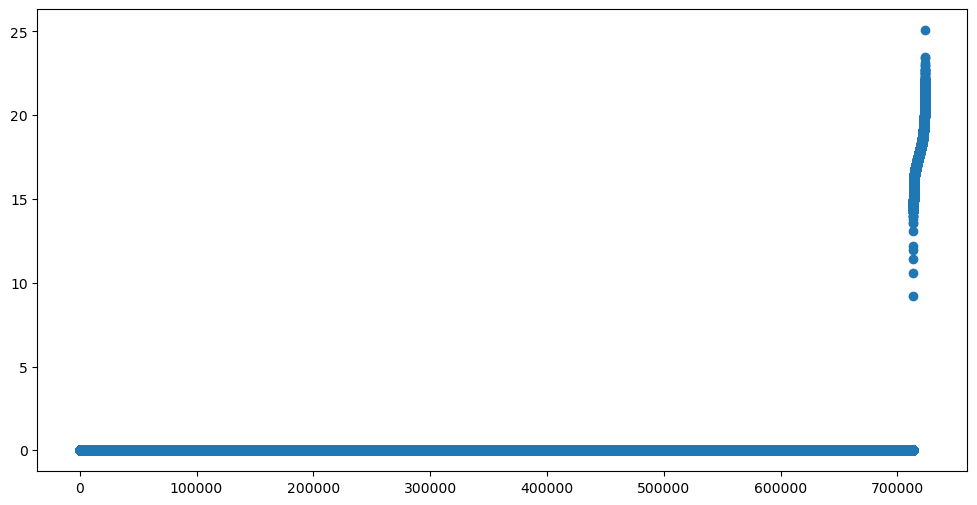

In [131]:
# Plotting the distribution of the total revenue
plt.figure(figsize=(12,6))
plt.scatter(range(gdf.shape[0]), np.sort(np.log1p(gdf["totals.transactionRevenue"].values)))

In [132]:
# check how many data we have for each column
count = df_dropped.count()
count = count.sort_values(ascending=False)
count

channelGrouping                                 903653
geoNetwork.subContinent                         903653
trafficSource.medium                            903653
trafficSource.source                            903653
trafficSource.campaign                          903653
date                                            903653
geoNetwork.networkDomain                        903653
geoNetwork.city                                 903653
geoNetwork.metro                                903653
geoNetwork.region                               903653
geoNetwork.country                              903653
totals.hits                                     903653
geoNetwork.continent                            903653
visitStartTime                                  903653
fullVisitorId                                   903653
device.deviceCategory                           903653
visitNumber                                     903653
visitId                                         903653
device.bro

In [133]:
"""
trafficSource.campaignCode                      0.999999
trafficSource.adContent                         0.987887
totals.transactionRevenue                       0.987257
trafficSource.adwordsClickInfo.isVideoAd        0.976252
trafficSource.adwordsClickInfo.adNetworkType    0.976252
trafficSource.adwordsClickInfo.slot             0.976252
trafficSource.adwordsClickInfo.page             0.976252
trafficSource.adwordsClickInfo.gclId            0.976140
trafficSource.isTrueDirect                      0.696781
trafficSource.referralPath                      0.633774
trafficSource.keyword                           0.556551
totals.bounces                                  0.501324
"""
#drop these columns
df_1 = df_dropped.drop(columns=['trafficSource.campaignCode', 'trafficSource.adContent', 
                                       'trafficSource.adwordsClickInfo.isVideoAd', 
                                      'trafficSource.adwordsClickInfo.adNetworkType', 
                                      'trafficSource.adwordsClickInfo.slot', 'trafficSource.adwordsClickInfo.page', 
                                      'trafficSource.adwordsClickInfo.gclId', 
                                      'trafficSource.isTrueDirect', 'trafficSource.referralPath', 
                                      'trafficSource.keyword', 'totals.bounces', 'fullVisitorId', 'visitId'])

# what if drop na
df_2 = df_1.dropna()

# check how many data left
count1 = df_1.count()
count1 = count1.sort_values(ascending=False)

count2 = df_2.count()
count2 = count2.sort_values(ascending=False)


print(count1)
print(count2)


channelGrouping              903653
geoNetwork.country           903653
trafficSource.source         903653
trafficSource.campaign       903653
totals.hits                  903653
geoNetwork.networkDomain     903653
geoNetwork.city              903653
geoNetwork.metro             903653
date                         903653
geoNetwork.region            903653
geoNetwork.subContinent      903653
geoNetwork.continent         903653
device.deviceCategory        903653
device.isMobile              903653
device.operatingSystem       903653
device.browser               903653
visitStartTime               903653
visitNumber                  903653
trafficSource.medium         903653
totals.pageviews             903553
totals.newVisits             703060
totals.transactionRevenue     11515
dtype: int64
channelGrouping              4465
date                         4465
trafficSource.source         4465
trafficSource.campaign       4465
totals.transactionRevenue    4465
totals.newVisits         

In [134]:
df_2.head()

,channelGrouping,date,visitNumber,visitStartTime,device.browser,device.operatingSystem,device.isMobile,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,...,geoNetwork.metro,geoNetwork.city,geoNetwork.networkDomain,totals.hits,totals.pageviews,totals.newVisits,totals.transactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium
752,Direct,20160902,1,1472843572,Chrome,Linux,False,desktop,Americas,Northern America,...,Detroit MI,Ann Arbor,(not set),11,11.0,1.0,37860000.0,(not set),(direct),(none)
893,Direct,20160902,1,1472861525,Safari,Macintosh,False,desktop,Americas,Northern America,...,San Francisco-Oakland-San Jose CA,San Jose,comcast.net,19,16.0,1.0,395730000.0,(not set),(direct),(none)
922,Organic Search,20160902,1,1472853332,Chrome,Android,True,mobile,Americas,Northern America,...,San Francisco-Oakland-San Jose CA,Mountain View,directmusicservice.com,22,16.0,1.0,35480000.0,(not set),google,organic
974,Organic Search,20160902,1,1472832496,Safari,iOS,True,mobile,Americas,Northern America,...,San Francisco-Oakland-San Jose CA,San Francisco,att.net,28,20.0,1.0,117340000.0,(not set),google,organic
976,Referral,20160902,1,1472879820,Chrome,Macintosh,False,desktop,Americas,Northern America,...,not available in demo dataset,not available in demo dataset,(not set),28,21.0,1.0,43710000.0,(not set),mall.googleplex.com,referral


In [135]:
df_2.head()

,channelGrouping,date,visitNumber,visitStartTime,device.browser,device.operatingSystem,device.isMobile,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,...,geoNetwork.metro,geoNetwork.city,geoNetwork.networkDomain,totals.hits,totals.pageviews,totals.newVisits,totals.transactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium
752,Direct,20160902,1,1472843572,Chrome,Linux,False,desktop,Americas,Northern America,...,Detroit MI,Ann Arbor,(not set),11,11.0,1.0,37860000.0,(not set),(direct),(none)
893,Direct,20160902,1,1472861525,Safari,Macintosh,False,desktop,Americas,Northern America,...,San Francisco-Oakland-San Jose CA,San Jose,comcast.net,19,16.0,1.0,395730000.0,(not set),(direct),(none)
922,Organic Search,20160902,1,1472853332,Chrome,Android,True,mobile,Americas,Northern America,...,San Francisco-Oakland-San Jose CA,Mountain View,directmusicservice.com,22,16.0,1.0,35480000.0,(not set),google,organic
974,Organic Search,20160902,1,1472832496,Safari,iOS,True,mobile,Americas,Northern America,...,San Francisco-Oakland-San Jose CA,San Francisco,att.net,28,20.0,1.0,117340000.0,(not set),google,organic
976,Referral,20160902,1,1472879820,Chrome,Macintosh,False,desktop,Americas,Northern America,...,not available in demo dataset,not available in demo dataset,(not set),28,21.0,1.0,43710000.0,(not set),mall.googleplex.com,referral


In [136]:
df_2.dtypes

channelGrouping               object
date                           int64
visitNumber                    int64
visitStartTime                 int64
device.browser                object
device.operatingSystem        object
device.isMobile                 bool
device.deviceCategory         object
geoNetwork.continent          object
geoNetwork.subContinent       object
geoNetwork.country            object
geoNetwork.region             object
geoNetwork.metro              object
geoNetwork.city               object
geoNetwork.networkDomain      object
totals.hits                    int64
totals.pageviews             float64
totals.newVisits             float64
totals.transactionRevenue    float64
trafficSource.campaign        object
trafficSource.source          object
trafficSource.medium          object
dtype: object

# NOT include Time Series


In [137]:
#type of each row
df_2.dtypes
#drop the date
df_3 = df_2.drop(columns=['date','geoNetwork.metro','geoNetwork.networkDomain','visitNumber','geoNetwork.city',
                          'visitStartTime','trafficSource.source'])
df_3.head()

,channelGrouping,device.browser,device.operatingSystem,device.isMobile,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,totals.hits,totals.pageviews,totals.newVisits,totals.transactionRevenue,trafficSource.campaign,trafficSource.medium
752,Direct,Chrome,Linux,False,desktop,Americas,Northern America,United States,Michigan,11,11.0,1.0,37860000.0,(not set),(none)
893,Direct,Safari,Macintosh,False,desktop,Americas,Northern America,United States,California,19,16.0,1.0,395730000.0,(not set),(none)
922,Organic Search,Chrome,Android,True,mobile,Americas,Northern America,United States,California,22,16.0,1.0,35480000.0,(not set),organic
974,Organic Search,Safari,iOS,True,mobile,Americas,Northern America,United States,California,28,20.0,1.0,117340000.0,(not set),organic
976,Referral,Chrome,Macintosh,False,desktop,Americas,Northern America,United States,not available in demo dataset,28,21.0,1.0,43710000.0,(not set),referral


In [138]:
#check the unique value of each column for categorical data
for col in df_3.columns:
    if df_3[col].dtype == 'object':
        print(col, df_3[col].nunique())
        print('\n')
        # print each unique value
        print(df_3[col].unique())
        print('\n')
        # print the value counts
        print(df_3[col].value_counts())
    else:
        continue


        

channelGrouping 8


['Direct' 'Organic Search' 'Referral' 'Paid Search' 'Social' 'Display'
 'Affiliates' '(Other)']


Organic Search    1657
Referral          1533
Direct             970
Paid Search        214
Social              47
Display             40
Affiliates           3
(Other)              1
Name: channelGrouping, dtype: int64
device.browser 8


['Chrome' 'Safari' 'Firefox' 'Safari (in-app)' 'Internet Explorer' 'Edge'
 'Android Webview' 'Opera']


Chrome               3821
Safari                428
Firefox               106
Internet Explorer      61
Edge                   33
Safari (in-app)         8
Android Webview         5
Opera                   3
Name: device.browser, dtype: int64
device.operatingSystem 6


['Linux' 'Macintosh' 'Android' 'iOS' 'Chrome OS' 'Windows']


Macintosh    2210
Windows      1073
iOS           312
Chrome OS     312
Linux         309
Android       249
Name: device.operatingSystem, dtype: int64
device.deviceCategory 3


['desktop' 'mobile' 'tablet']


In [139]:
df_4 = df_3.drop(columns=['geoNetwork.subContinent','trafficSource.campaign','geoNetwork.continent'])


In [140]:


# Assuming your DataFrame is named df (replace with the actual name of your DataFrame)

# Filter the DataFrame to include only rows where 'geoNetwork.country' is 'United States' or 'Canada'
df_4= df_4[(df_4['geoNetwork.country'] == 'United States')]

# drop country column
df_4 = df_4.drop(columns=['geoNetwork.country'])

# Now, filtered_df contains only the rows with 'United States' and 'Canada'


print(df_4['geoNetwork.region'].unique())


['Michigan' 'California' 'not available in demo dataset' 'Illinois'
 'Oregon' 'New York' 'District of Columbia' 'Washington' 'Massachusetts'
 'Texas' 'Colorado' 'North Carolina' 'New Jersey' 'Georgia' 'Utah'
 'Pennsylvania' 'Arizona' 'Virginia' 'Iowa' 'Tennessee' '(not set)'
 'Missouri' 'Minnesota' 'Florida' 'Nevada' 'Zulia' 'Indiana' 'Connecticut'
 'Wisconsin' 'Ohio']


In [141]:
df_4['channelGrouping'] = df_4['channelGrouping'].replace(['Social', 'Display', 'Affiliates', '(Other)'], 'Other')
print(df_4['channelGrouping'].value_counts())


browsers_to_keep = ['Chrome']
df_4['device.browser'] = df_4['device.browser'].apply(lambda x: x if x in browsers_to_keep else 'Rest')
# After the modification, to see the count of each category, you can use value_counts()
print(df_4['device.browser'].value_counts())


# For the 'device.operatingSystem' column
# Replace 'Macintosh' with 'Mac', 'Windows' remains the same, and classify others as 'Mobile'
df_4['device.operatingSystem'] = df_4['device.operatingSystem'].replace(['Linux', 'Android', 'iOS', 'Chrome OS'], 'Mobile')
df_4['device.operatingSystem'] = df_4['device.operatingSystem'].replace(['Macintosh'], 'Mac')

# Assuming 'device.deviceCategory' needs to be updated based on 'device.operatingSystem'
# This step seems a bit confusing because 'deviceCategory' typically indicates the type of device (e.g., desktop, mobile, tablet)
# If you intended to classify 'deviceCategory' based on 'operatingSystem', let's clarify the approach:
# - 'Mac' and 'Windows' could be considered 'desktop' in many contexts
# - 'Mobile' could map to 'mobile' and 'tablet'
# If the task is to adjust 'device.deviceCategory' based on these new 'operatingSystem' categories:
df_4['device.deviceCategory'] = df_4['device.operatingSystem'].apply(lambda x: 'desktop' if x in ['Mac', 'Windows'] else 'mobile')

# drop device category
df_4 = df_4.drop(columns=['device.deviceCategory'])

# After reclassification, to see the count of each category in 'device.operatingSystem'
print(df_4['device.operatingSystem'].value_counts())


df_4['geoNetwork.region'] = df_4['geoNetwork.region'].replace(['not available in demo dataset', '(not set)'], 'Unknown')


Organic Search    1520
Referral          1504
Direct             912
Paid Search        213
Other               89
Name: channelGrouping, dtype: int64
Chrome    3644
Rest       594
Name: device.browser, dtype: int64
Mac        2119
Mobile     1135
Windows     984
Name: device.operatingSystem, dtype: int64


In [142]:
for col in df_4.columns:
    if df_4[col].dtype == 'object':
        print(col, df_4[col].nunique())
        print('\n')
        # print each unique value
        print(df_4[col].unique())
        print('\n')
        # print the value counts
        print(df_4[col].value_counts())
    else:
        continue


channelGrouping 5


['Direct' 'Organic Search' 'Referral' 'Paid Search' 'Other']


Organic Search    1520
Referral          1504
Direct             912
Paid Search        213
Other               89
Name: channelGrouping, dtype: int64
device.browser 2


['Chrome' 'Rest']


Chrome    3644
Rest       594
Name: device.browser, dtype: int64
device.operatingSystem 3


['Mobile' 'Mac' 'Windows']


Mac        2119
Mobile     1135
Windows     984
Name: device.operatingSystem, dtype: int64
geoNetwork.region 29


['Michigan' 'California' 'Unknown' 'Illinois' 'Oregon' 'New York'
 'District of Columbia' 'Washington' 'Massachusetts' 'Texas' 'Colorado'
 'North Carolina' 'New Jersey' 'Georgia' 'Utah' 'Pennsylvania' 'Arizona'
 'Virginia' 'Iowa' 'Tennessee' 'Missouri' 'Minnesota' 'Florida' 'Nevada'
 'Zulia' 'Indiana' 'Connecticut' 'Wisconsin' 'Ohio']


Unknown                 1930
California              1136
New York                 516
Illinois                 135
Washington               117
Texas   

In [143]:
df_4['trafficSource.medium'] = df_4['trafficSource.medium'].replace('(none)', 'none')

# Combine 'cpc', 'cpm', 'affiliate', and '(not set)' into 'rest'
df_4['trafficSource.medium'] = df_4['trafficSource.medium'].replace(['cpc', 'cpm', 'affiliate', '(not set)'], 'rest')

# After reclassification, to see the count of each category
print(df_4['trafficSource.medium'].value_counts())

referral    1549
organic     1520
none         912
rest         257
Name: trafficSource.medium, dtype: int64


In [144]:
import pandas as pd

# Assuming your DataFrame is named df and already has 'Unknown' consolidated

# Define the states as 'West' or 'East'
west_states = ['California', 'Washington', 'Texas', 'Colorado', 'Arizona', 'Oregon', 'Nevada', 'Utah']
east_states = ['New York', 'Illinois', 'Michigan', 'Massachusetts', 'Georgia', 'District of Columbia', 
               'Pennsylvania', 'New Jersey', 'North Carolina', 'Minnesota', 'Missouri', 'Florida', 
               'Tennessee', 'Iowa', 'Virginia', 'Indiana', 'Connecticut']

# Function to categorize each state
def categorize_state(region):
    if region in west_states:
        return 'West'
    elif region in east_states:
        return 'East'
    else:
        return 'Unknown'  # Keeps 'Unknown' and other unspecified regions as 'Unknown'

# Apply the categorization
df_4['geoNetwork.region'] = df_4['geoNetwork.region'].apply(categorize_state)

# Check the new categorization
print(df_4['geoNetwork.region'].value_counts())


Unknown    1933
West       1407
East        898
Name: geoNetwork.region, dtype: int64


In [145]:
for col in df_4.columns:
    if df_4[col].dtype == 'object':
        print(col, df_4[col].nunique())
        print('\n')
        # print each unique value
        print(df_4[col].unique())
        print('\n')
        # print the value counts
        print(df_4[col].value_counts())
    else:
        continue


channelGrouping 5


['Direct' 'Organic Search' 'Referral' 'Paid Search' 'Other']


Organic Search    1520
Referral          1504
Direct             912
Paid Search        213
Other               89
Name: channelGrouping, dtype: int64
device.browser 2


['Chrome' 'Rest']


Chrome    3644
Rest       594
Name: device.browser, dtype: int64
device.operatingSystem 3


['Mobile' 'Mac' 'Windows']


Mac        2119
Mobile     1135
Windows     984
Name: device.operatingSystem, dtype: int64
geoNetwork.region 3


['East' 'West' 'Unknown']


Unknown    1933
West       1407
East        898
Name: geoNetwork.region, dtype: int64
trafficSource.medium 4


['none' 'organic' 'referral' 'rest']


referral    1549
organic     1520
none         912
rest         257
Name: trafficSource.medium, dtype: int64


In [146]:
df_4.drop(columns=['device.isMobile'], inplace=True)    
